In [2]:
from nltk.tokenize import RegexpTokenizer
import pandas as pd
import numpy as np
import re
from nltk.tokenize import  sent_tokenize
from transformers import Trainer, TrainingArguments, LEDTokenizer, LEDForConditionalGeneration, AutoModel
from torch.utils.data import DataLoader, Dataset
import transformers
import torch

In [3]:
class preprocess:
    def __init__(self, file_path):
        # Tokenization and cleaning related variable
        self.regex_tokenizer = RegexpTokenizer(r"[a-zA-Z0-9]+|\.(?![a-zA-Z0-9])")
        self.stopwords = ['the','of','to']
        
        # Model related variables
        self.encoder_max_token = 16384
        self.decoder_max_token = 1024
        self.LED_tokenizer = LEDTokenizer.from_pretrained("allenai/led-base-16384")
        self.LED_model = LEDForConditionalGeneration.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)
        self.global_mask = []

        # Data related variables
        self.df = pd.read_csv(file_path)
        self.court_cases = []
        self.rulings = []
        self.issues = []
        self.facts = []
        self.decoder_court = []
        self.decoder_ruling = []
        self.decoder_facts = []
        self.decoder_issues = []

        # Actual Data input to the model
        self.encoder_inputs = []
        self.decoder_inputs = []
        self.global_mask = []
        self.final_data = []

        # Unknown token variables
        try:
            with open('unknown_tokens.txt', 'r') as f:
                self.unknown_tokens = f.read().splitlines()
        except:
            self.unknown_tokens = []
        self.found_new_unknown_token = False

        # Preprocess and prepare raw data
        self.df.dropna(inplace=True)
        self.df = self.df.drop_duplicates()
        self.preprocess()
        self.find_unknown_token()
        if self.found_new_unknown_token:
            self.add_tokens_tokenizer_model()
        self.add_specialtoken_globalmask()
        self.prepare_LED_data()

    def return_model_tokenizer_data(self):
        return self.LED_model, self.LED_tokenizer, self.final_data

    def prepare_LED_data(self):
        # length of encoder and decoder inputs are the same and should be a list of strings
        for i in range(len(self.encoder_inputs)):
            # Tokenize the input (court case text)
            inputs = self.LED_tokenizer(self.encoder_inputs[i], 
                               max_length=self.encoder_max_token, 
                               padding="max_length", 
                               truncation=True, 
                               return_tensors="pt")
            
            # Tokenize the output (segmentation)
            outputs = self.LED_tokenizer(self.decoder_inputs[i], 
                                max_length=self.decoder_max_token,
                                padding="max_length", 
                                truncation=True, 
                                return_tensors="pt")
            
            input_ids = inputs.input_ids
            attention_mask = inputs.attention_mask

            # prepare label
            labels = outputs.input_ids.clone()

            # ensure global_attention_mask is padded to the correct length
            global_attention_mask = self.global_mask[i]
            if len(global_attention_mask) < 16384:
                padding_length = 16384 - len(global_attention_mask)
                global_attention_mask = global_attention_mask + [0] * padding_length
    
            global_attention_mask = torch.tensor(global_attention_mask).unsqueeze(0)  # convert to tensor and match input shape

            # prepare final data structure
            data = {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "global_attention_mask": global_attention_mask,
                "labels": labels
            }

            # append final data
            self.final_data.append(data)
        
        
    def add_specialtoken_globalmask(self):
        '''
        Add special tokens to the segment when it switches labels. Add global mask to the first 3 tokens of the start of each segment.
        
        Example: "<RULING> the courts ruling is in this text. this text is also about ruling. 
        <ISSUES> this text is about issue. <FACTS> this text is facts. <RULING> this is a text for ruling. <FACTS> this text is also facts."
        '''
        # Join tokens to form full strings for each case
        self.decoder_court = [' '.join(token) for token in self.court_cases]
        self.decoder_ruling = [' '.join(token) for token in self.rulings]
        self.decoder_facts = [' '.join(token) for token in self.facts]
        self.decoder_issues = [' '.join(token) for token in self.issues]
    
        # Split into sentences
        self.decoder_court = [sent_tokenize(text) for text in self.decoder_court]
        self.decoder_ruling = [sent for text in self.decoder_ruling for sent in sent_tokenize(text)]
        self.decoder_facts = [sent for text in self.decoder_facts for sent in sent_tokenize(text)]
        self.decoder_issues = [sent for text in self.decoder_issues for sent in sent_tokenize(text)]
    
        # Prepare encoder/decoder inputs and global attention mask
        current_label = ''
        for sentences in self.decoder_court:
            list_encoder = []
            list_decoder = []
            list_attntn = []
            for sentence in sentences:  # process each sentence one by one
                # Tokenize each sentence
                token = self.regex_tokenizer.tokenize(sentence)
                global_attntn = []

                if sentence in self.decoder_facts:
                    list_encoder.append(' '.join(token))
                    
                    if current_label != "<FACTS>":
                        # Add special token and set global attention for the first 3 tokens
                        token = ["<FACTS>"] + token
                        global_attntn = [1] * 3 + [0] * (len(token) - 3)
                    else:
                        global_attntn = [0] * len(token)
                    
                    # Append to decoder inputs and global mask
                    list_decoder.append(' '.join(token))
                    list_attntn.append(global_attntn)
                    current_label = "<FACTS>"

                elif sentence in self.decoder_ruling:
                    list_encoder.append(' '.join(token))
                    
                    if current_label != "<RULING>":
                        # Add special token and set global attention for the first 3 tokens
                        token = ["<RULING>"] + token
                        global_attntn = [1] * 4 + [0] * (len(token) - 4)
                    else:
                        global_attntn = [0] * len(token)
                    
                    # Append to decoder inputs and global mask
                    list_decoder.append(' '.join(token))
                    list_attntn.append(global_attntn)
                    current_label = "<RULING>"
                    
                elif sentence in self.decoder_issues:
                    list_encoder.append(' '.join(token))
                    
                    if current_label != "<ISSUES>":
                        # Add special token and set global attention for the first 2 tokens
                        token = ["<ISSUES>"] + token
                        global_attntn = [1] * 2 + [0] * (len(token) - 2)
                    else:
                        global_attntn = [0] * len(token)
                    
                    # Append to decoder inputs and global mask
                    list_decoder.append(' '.join(token))
                    list_attntn.append(global_attntn)
                    current_label = "<ISSUES>"
                    
            # Flatten the list of list of tokens and attentions
            self.encoder_inputs.append(' '.join(list_encoder))
            self.decoder_inputs.append(' '.join(list_decoder))
            self.global_mask.append([attntn for attntns in list_attntn for attntn in attntns])

                
    def add_tokens_tokenizer_model(self):
        '''
        Add unknown token including special tokens to the tokenizer and resize the token embedding of the model.
        '''
        # Add special tokens if not in tokenizer
        special_tokens = ['<RULING>', '<ISSUES>', '<FACTS>']
        if not set(special_tokens).issubset(set(self.unknown_tokens)):
            self.unknown_tokens.extend(special_tokens)
                    
        # Add the new tokens to the tokenizer
        self.tokenizer.add_tokens(self.unknown_tokens)

        # Resize the model's token embeddings to match the new tokenizer length
        self.LED_model.resize_token_embeddings(len(self.tokenizer))

    def find_unknown_token(self):
        '''
        Iterate over each cases, converting the tokens into IDs. Check if there is an unknown token in input_ids
        '''
        for case_tokens in self.court_cases:
            input_ids = self.LED_tokenizer.convert_tokens_to_ids(case_tokens)
            for input_id in input_ids:
                if input_ids == 100 and input_ids not in self.unknown_tokens:
                    print(case_tokens[i]," : ",input_ids[i])
                    self.found_new_unknown_token = True
                    self.unknown_tokens.append(case_tokens[i])

    def preprocess(self):
        '''
        Clean characters and tokenize court cases and segments.
        '''
        # Lowercase the text and Remove unnecessary characters
        self.court_cases = [self.change_char(text.lower()) for text in self.df["whole_text"]]
        self.rulings = [self.change_char(text.lower()) for text in self.df["ruling"]]
        self.facts = [self.change_char(text.lower()) for text in self.df["facts"]]
        self.issues = [self.change_char(text.lower()) for text in self.df["issues"]]
        
        # Tokenize the text, storing words and numbers only
        self.court_cases = [self.regex_tokenizer.tokenize(text) for text in self.court_cases]
        self.rulings = [self.regex_tokenizer.tokenize(text) for text in self.rulings]
        self.facts = [self.regex_tokenizer.tokenize(text) for text in self.facts]
        self.issues = [self.regex_tokenizer.tokenize(text) for text in self.issues]

        # Remove stopwords
        self.court_cases = [self.removestop(token_list) for token_list in self.court_cases]
        self.rulings = [self.removestop(token_list) for token_list in self.rulings]
        self.facts = [self.removestop(token_list) for token_list in self.facts]
        self.issues = [self.removestop(token_list) for token_list in self.issues]

    def removestop(self, token_list):
        """
        Remove stopwords from a list of tokens. Handles case where stopwords are in lower case.
        """
        return [token for token in token_list if token.lower() not in self.stopwords]

    def change_char(self, text):
        """
        Cleans up text by removing or replacing certain characters and patterns.
    
        Args:
            text: A string to be cleaned.
    
        Returns:
            A cleaned version of the string.
        """
        # More specific substitutions first
        text = re.sub(r"\bno.", "number ", text, flags=re.IGNORECASE)  # Replace "no." with "number"
        text = re.sub(r"r.a.", "ra ", text, flags=re.IGNORECASE)    # Replace "R.A." with "ra"
        text = re.sub(r"section (\d+)\.", r"section \1", text) # Replace "section N." with "section N" where N is a number
        text = re.sub(r"sec.", r"sec", text) # Replace "section N." with "section N" where N is a number
        text = re.sub(r"([a-z])\.", r"\1", text)# Remove dots following single letters
        text = re.sub(r"\brtc\b", "regional trial court", text)  # Replace "rtc" with "regional trial court"
        
        # Remove unwanted characters, but keep periods at the end of words
        text = re.sub(r"[(),:;'\"’”\[\]]", " ", text)   # Remove specific punctuation
        text = re.sub(r"(?<!\w)\.", " ", text)  # Remove isolated periods (not following word characters)s
    
        # Remove stray or special characters
        text = re.sub(r"[“”]", " ", text)              # Remove “ and ”
        text = re.sub(r"\u2033", " ", text)            # Remove double prime (″)
        text = re.sub(r"\u2032", " ", text)            # Remove prime (′)
        
        # Remove specific meaningless characters
        text = re.sub(r"\bg\b", " ", text)
        text = re.sub(r"\br\b", " ", text)
    
        # Return cleaned text
        return text

In [4]:
tokenizer = LEDTokenizer.from_pretrained("allenai/led-base-16384")
model = LEDForConditionalGeneration.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)
file_path = 'new_court_cases.csv'

C:\Users\mdfl0\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\mdfl0\AppData\Roaming\Python\Python311\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [5]:
# Prepare the data, model, and tokenizer before training
preprocessor = preprocess(file_path, tokenizer, model)

In [6]:
model, tokenizer, data = preprocessor.return_model_tokenizer_data()

In [9]:
from visualization import *
visualizer = visualization

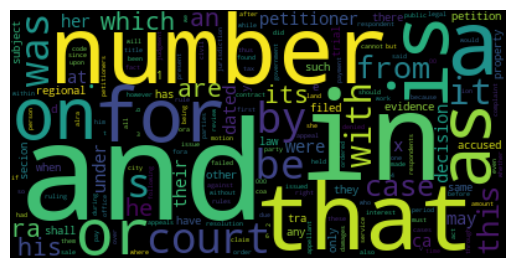

In [10]:
visualizer.wordcloud(preprocessor.court_cases)

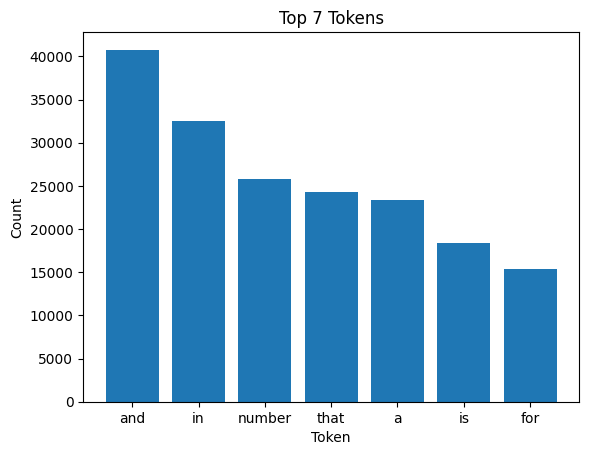

In [11]:
visualizer.plot_top_tokens(preprocessor.court_cases)

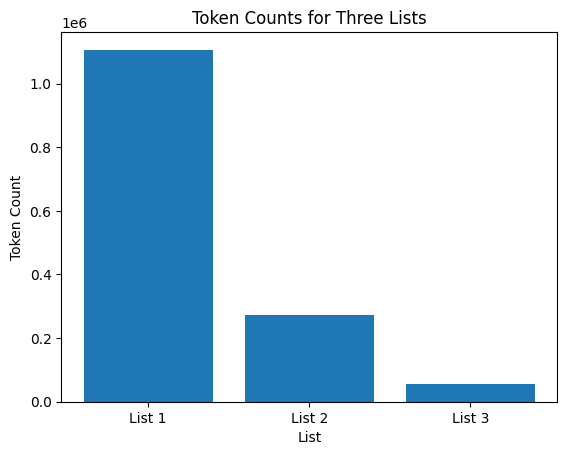

In [12]:
visualizer.plot_token_counts(preprocessor.rulings, preprocessor.facts, preprocessor.issues)

In [13]:
visualizer.average_token_length(preprocessor.court_cases)

average court case length:  4421.833846153846
highest court case length:  14426
lowest court case length:  971


In [14]:
visualizer.print_average(preprocessor.rulings, preprocessor.facts, preprocessor.issues)

List 1: 77.25%
List 2: 18.96%
List 3: 3.78%
